### Выполним импорт необходимых библиотек

In [188]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [189]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Загрузим данные в наш DataFrame

In [190]:
raw_data = pd.read_csv('train.csv', header=0, sep=',')

In [191]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


### Data Fields

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

### Посмотрим на размерность данных

In [192]:
print raw_data.shape

(10886, 12)


### Посмотрим на пропущенные значения

In [193]:
raw_data.isnull().values.any()

False

### Предобработка данных

In [194]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


### Почти все данные являются числовыми кроме поля datetime, но мы знаем, что это дата (необходимо преобразование)

In [195]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

#### Построим два новых признака month/hour

In [196]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [197]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,1,4


#### Обучение и отложенный тест 

#### Данные отсортированы по дате, обучимся на более поздних датах, и предскажем на более новых

In [198]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

#### Оценим размеры полученных наборов данных

In [199]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


#### Убедимся, что вся обучающая выборка в более раннем периоде времени

In [200]:
print 'train period from {} to {}'.format(train_data.datetime.min(),
                                            train_data.datetime.max())
print 'test period from {} to {}'.format(hold_out_test_data.datetime.min(),
                                            hold_out_test_data.datetime.max())

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
test period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

### Удалим дату и целевую переменную, чтобы было удобнее работать с признаками

In [201]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime','count'], axis=1)

In [202]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime','count'], axis=1)

### Целевая функция на обучающей выборке и на отложенном тесте

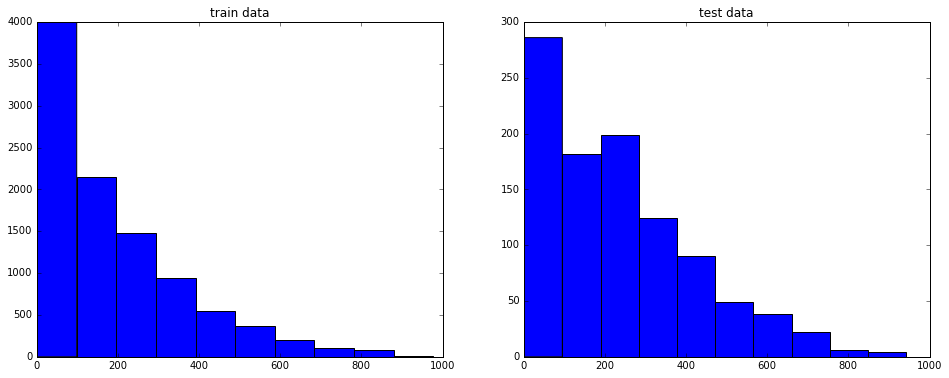

In [203]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')


pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### 

#### Так как мы решаем задачу регрессии, то  возьмем пока только числовые признаки

In [204]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [205]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [206]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


In [207]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


#### Модель

### Обучим SGDRegressor - регрессия на основе стохастического градиентного спуска

In [208]:
regressor = linear_model.SGDRegressor(random_state=0)

### Используем параметры по умолчанию

In [209]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

23756929732818.266

#### Выведим тестовые метки и те что предсказали, чтобы увидеть разницу

In [210]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [211]:
print regressor.predict(test_data)[:10]

[ -5.49937759e+13  -8.85325874e+13  -3.70533023e+13  -2.25065153e+13
  -2.37308393e+13  -3.38802477e+13  -3.40698991e+13  -3.17048874e+13
  -3.61620909e+13  -4.69681797e+13]


### Мы выводим слишком большие значения

In [212]:
regressor.coef_

array([  3.32334025e+10,   2.30830830e+10,   3.12573533e+10,
        -4.53893233e+10,  -1.00561685e+11,  -1.09157806e+11,
        -7.94127090e+10,   1.01775965e+10])

### Линейные модели сильно зависят от масштаба признаков

### Scaling

In [213]:
from sklearn.preprocessing import StandardScaler

In [214]:
## создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [215]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.1179376296343153

In [216]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [217]:
print regressor.predict(scaled_test_data)[:10]

[ 524.82767322  834.83176277  354.85768824  221.89221002  227.84049612
  324.88196372  327.8982227   307.9347954   345.90146969  445.90141764]


#### Отличаются примерно на 1. Скорее всего присутствует переобучение

In [218]:
print regressor.coef_

[  1.41019246e+00  -1.40725539e+00   1.45346928e-02  -4.38984175e-02
   5.08589954e+01   1.48004811e+02  -8.23376876e-03   6.37720415e-03]


#### Выведим коэффициенты с округлением

In [219]:
print map(lambda x : round(x, 2), regressor.coef_)

[1.41, -1.41, 0.01, -0.04, 50.86, 148.0, -0.01, 0.01]


In [220]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


### Похоже casual + registered = count
#### Необходимо проверить гипотезу

In [221]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [222]:
np.all(train_data.registered + train_data.casual == train_labels)

True

###  У нас линейная зависимость, которая полностью восстанавливает закономерность, значит, необходимо удалить эти признаки из выборки

In [223]:
train_data.drop(['registered', 'casual'], axis=1, inplace=True)
test_data.drop(['registered', 'casual'], axis=1, inplace=True)

#### Масштабируем признаки

In [224]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [225]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.81123864993025

#### Мы ошибаемся примерно на 122 велосипеда  - реалистичная оценка

In [226]:
print map(lambda x : round(x, 2), regressor.coef_)

[31.03, 29.96, -41.93, 6.17, 14.08, 49.6]


### Теперь все признаки имеют хорошие коэффициенты

#### Мы уже имеем некоторую базовую модель, которую считаем правильной. Проведем ее улучшения

#### Подберем оптимальные параметры для нашей модели

#### Pipeline

In [227]:
# создаем pipeline из 2х шагов: scaling и классификация
pipe_line = pipeline.Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [228]:
pipe_line.fit_transform(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipe_line.predict(test_data))

C:\Users\got\Anaconda2\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


121.81123864993025

### Перебор параметров

In [229]:
pipe_line.get_params().keys()

['regression__random_state',
 'regression__n_iter',
 'regression__epsilon',
 'regression__power_t',
 'regression__alpha',
 'regression__eta0',
 'regression__loss',
 'scaling',
 'steps',
 'scaling__copy',
 'regression__fit_intercept',
 'regression__warm_start',
 'regression__penalty',
 'regression__learning_rate',
 'regression__average',
 'regression__verbose',
 'regression__shuffle',
 'regression__l1_ratio',
 'regression',
 'scaling__with_std',
 'scaling__with_mean']

In [230]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__n_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [231]:
grid_cv = grid_search.GridSearchCV(pipe_line, parameters_grid, scoring='mean_absolute_error', cv=4)

In [232]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 27 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'regression__n_iter': [3, 5, 10, 50], 'regression__loss': ['huber', 'epsilon_insensitive', 'squared_loss'], 'scaling__with_mean': [0.0, 0.5], 'regression__alpha': [0.0001, 0.01], 'regression__penalty': ['l1', 'l2', 'none']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

#### Лучшая оценка и лучшие параметры равны

In [233]:
print grid_cv.best_score_
print grid_cv.best_params_

-108.614496603
{'regression__n_iter': 3, 'regression__loss': 'squared_loss', 'scaling__with_mean': 0.0, 'regression__alpha': 0.01, 'regression__penalty': 'l2'}


#### Оценка лучшей модели на отложенном тесте

In [234]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935379

In [235]:
np.mean(test_labels)

232.15899999999999

In [236]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [237]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [238]:
print test_predictions[:10]

[ 139.60470681  159.80765341  207.55935972  237.76288054  257.83836668
  267.44558034  272.49537469  297.70688522  304.29818873  313.58821156]


#### Предсказанные и реальные метки сильно отличаются

#### Изобразим графически отображение в пространстве правильных целевых меток и наших предсказаний
#### (ожидаем диагональ в облаке точек)

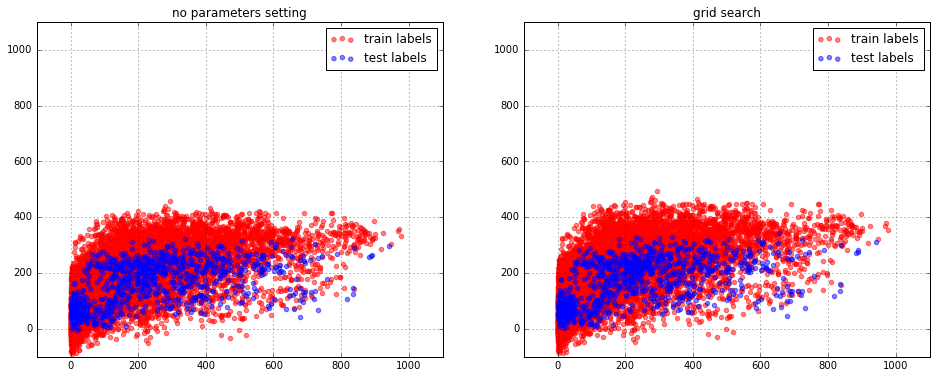

In [239]:
pylab.figure(figsize=(16,6))

pylab.subplot(1,2,1)
pylab.grid(True)
train = pylab.scatter(train_labels, pipe_line.predict(train_data), alpha = 0.5, color = 'red')
test = pylab.scatter(test_labels, pipe_line.predict(test_data), alpha = 0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.legend([train, test], ['train labels', 'test labels'])

pylab.subplot(1,2,2)
pylab.grid(True)
train_cv = pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha = 0.5, color = 'red')
test_cv = pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha = 0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.legend([train_cv, test_cv], ['train labels', 'test labels'])



### Фактически - наша модель слабая и оптимизация по параметрам ничего не дала!

In [240]:
# Считаем наши данные еще раз
raw_data = pd.read_csv('train.csv', header=0, sep=',')
# convert
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data.drop(['registered', 'casual'], axis=1, inplace=True)
# new features
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)
# split dataset
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]
# оценим выборку

print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 12) (9886, 12) (1000, 12)


In [241]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime','count'], axis=1)

#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime','count'], axis=1)

##### Преобразуем данные, чтобы все они были представлены числовым типом

#### Необходимо получить логический индекс

#### Логический индекс для бинарных данных

In [242]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [243]:
print binary_data_columns
print binary_data_indices

['holiday', 'workingday']
[False  True  True False False False False False False False]


#### Логический индекс для категориальных данных

In [244]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [245]:
print categorical_data_columns
print categorical_data_indices

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


### Логический индекс для числовых данных

In [246]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [247]:
print numeric_data_columns
print numeric_data_indices

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


#### Pipeline

In [248]:
grid_cv.best_params_

{'regression__alpha': 0.01,
 'regression__loss': 'squared_loss',
 'regression__n_iter': 3,
 'regression__penalty': 'l2',
 'scaling__with_mean': 0.0}

In [249]:
regressor = linear_model.SGDRegressor(random_state=241)

#### Используем Pipeline для более удобного выполнения последовательных задач

In [250]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [251]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000001A0736D8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...5, penalty='l2', power_t=0.25,
       random_state=241, shuffle=True, verbose=0, warm_start=False))])

In [252]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

117.92322942489109

### Мы получили достаточно большую ошибку - примерно то же самое, что и было раньше т.е. мы не получили улучшение путем преобразование данных

#### Посмотрим, возможно, подбор параметр сможет на это повлиять

In [253]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__transformer_weights',
 'feature_processing__transformer_list',
 'model_fitting__fit_intercept',
 'feature_processing',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',
 'model_fitting__l1_ratio',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'feature_processing__categorical_variables_processing__hot_encoding_

In [254]:
parameters_grid = {
    'model_fitting__alpha' : [0.001, 0.01, 0.1],
    'model_fitting__eta0' : [0.1, 0.02, 0.003]
}

In [255]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid,
                                   scoring='mean_absolute_error', 
                                  cv=4)

In [256]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 1.34 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000001A0736D8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...5, penalty='l2', power_t=0.25,
       random_state=241, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.1, 0.02, 0.003], 'model_fitting__alpha': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [257]:
print grid_cv.best_score_
print grid_cv.best_params_

-116.236044605
{'model_fitting__eta0': 0.003, 'model_fitting__alpha': 0.1}


### Оценка по отложенному тесту

In [258]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [259]:
metrics.mean_absolute_error(test_labels, test_predictions)

120.55158719067019

##### Мы ошибаемся в среднем на 146 велосипедов, чуть лучше, чем было, но попрежнему очень и очень плохо, т.е. оптимизация параметров не принесла результатов

In [260]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [261]:
print test_predictions[:20]

[ 155.7045484   173.4269604   222.28658931  250.57980664  271.09395482
  279.53682588  284.85928849  307.87471893  316.22330884  324.29766437
  319.08052136  312.28385697  292.30490552  280.4134165   273.97299528
  251.42598434  253.37954046   69.32820481   76.64483436   83.96146392]


#### Отобразим наши объекты в координатах исходных значений и наших прогнозов

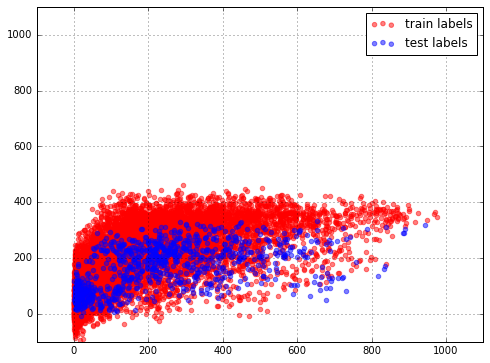

In [262]:
pylab.figure(figsize=(8, 6))

pylab.grid(True)
train = pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha = 0.5, color = 'red')
test = pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha = 0.5, color = 'blue')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.legend([train, test], ['train labels', 'test labels'])

### Область точек достаточно далека от диагональной области точек, которая получится в случае хорошей модели; Наш график сильно похож на графики выше, следовательно, все наши преобразования - генерация новых признаков подбор параметров не привели к улучшению модели - мы не смогли ее улучшить

###  Мы строим линейную модель, это предполагает линейную зависимость между признаками и целевой переменной. Но это не всегда так - например, количество занятых велосипедов линейно зависят от времени - на каком-то отрезке это будет линейной зависимостью - количество занятых от времени, но на других отрезках наоборот. Эти же рассуждения можно применить к другим признакам - например, температуре, месяцу, давлению.

* Можно сгенерировать новые признаки
* Использовать другую модель (которые умеют учитывать не линейную зависимость между признаками и целевой функцией)

#### Попробуем логарифмировать признаки

In [263]:
regressor = linear_model.SGDRegressor(random_state=0)

In [264]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: np.log(data[:, numeric_data_indices]+2)))
#                 ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [265]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000001A4E3F28>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...r=5, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))])

In [266]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

115.8576608559575

### Мы смогли незначительно снизить ошибку линейной модели, используя обычное логарифмирование

#### Попробуем теперь нелинейную модель

#### Обучим нелинейную модель

In [267]:
from sklearn.ensemble import RandomForestRegressor

In [268]:
regressor = RandomForestRegressor(random_state = 0, max_depth=20, n_estimators=50)

In [269]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [270]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000D5663C8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [271]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.465803762612722

In [272]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [273]:
estimator.predict(test_data)[:20]

array([ 409.565     ,  505.56      ,  256.14066667,  165.5502619 ,
        206.48474784,  265.73960439,  254.49615818,  317.85774486,
        282.66963263,  441.59333333,  723.04714286,  674.72464286,
        432.46666667,  319.4       ,  211.06      ,  160.98      ,
         94.16      ,   25.2       ,   12.26      ,    7.2325    ])

#### Отобразим наши объекты в координатах исходных значений целевой метки и наших прогнозов

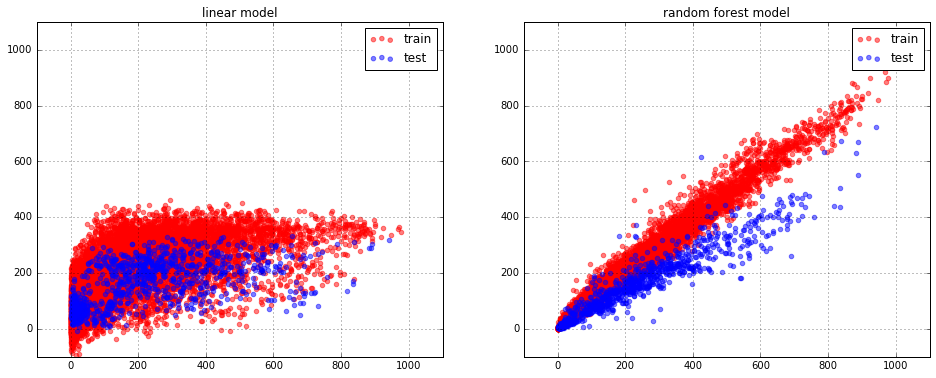

In [274]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
train_cv = pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
test_cv = pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')
pylab.legend([train_cv, test_cv], ['train', 'test'])
pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
train_est = pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
test_est = pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')
pylab.legend([train_est, test_est], ['train', 'test'])

### Попробуем улучшить модель не масштабируя, а логарифмируя признаки

In [275]:
regressor = RandomForestRegressor(random_state = 0, max_depth=20, n_estimators=50)

In [111]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: np.log(data[:, numeric_data_indices]+2)))
#                 ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [112]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000EA06BA8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [113]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.436502024838788

#### Ошибка уменьшилась незначительно, но это нельзя назвать успехом

#### Попробуем улучшить модель, подобрав параметры

In [135]:
regressor = RandomForestRegressor(random_state = 0, max_depth=20, n_estimators=50)
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000112E75F8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [136]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'model_fitting__oob_score',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__transformer_weights',
 'model_fitting__min_samples_leaf',
 'feature_processing__transformer_list',
 'model_fitting__n_estimators',
 'model_fitting__criterion',
 'model_fitting__max_leaf_nodes',
 'feature_processing',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'f

### Произведем подбор оптимальных параметров

In [137]:
parameters_grid = {
    'model_fitting__n_estimators': [20, 50],
    'model_fitting__max_depth':[5,25, 50]
}

In [138]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid,
                                   scoring='mean_absolute_error', 
                                  cv=4)

In [139]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 3min 50s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000112E75F8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__max_depth': [5, 25, 50], 'model_fitting__n_estimators': [20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [140]:
print grid_cv.best_score_
print grid_cv.best_params_

-80.1506330766
{'model_fitting__max_depth': 50, 'model_fitting__n_estimators': 50}


In [155]:
test_predictions = grid_cv.best_estimator_.predict(test_data)
metrics.mean_absolute_error(test_labels, test_predictions)

79.61066933333332

In [156]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [157]:
estimator.predict(test_data)[:20]

array([ 409.565     ,  505.56      ,  256.14066667,  165.5502619 ,
        206.48474784,  265.73960439,  254.49615818,  317.85774486,
        282.66963263,  441.59333333,  723.04714286,  674.72464286,
        432.46666667,  319.4       ,  211.06      ,  160.98      ,
         94.16      ,   25.2       ,   12.26      ,    7.2325    ])

#### Отобразим наши объекты в координатах исходных значений целевой метки и наших прогнозов

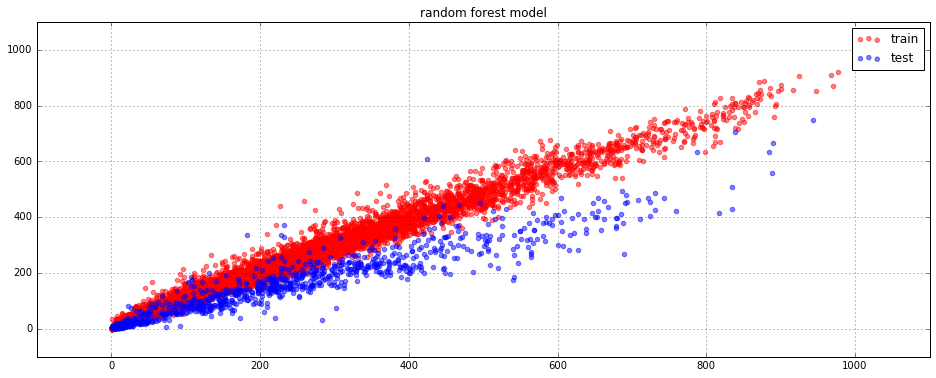

In [158]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
train_rfr = pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
test_rfr = pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')
pylab.legend([train_rfr, test_rfr], ['train', 'test'])

### Теперь попробуем добавить логарифмирование признаков и подобрать оптимальные параметры

In [167]:
regressor = RandomForestRegressor(random_state = 0, max_depth=20, n_estimators=50)
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: np.log(data[:, numeric_data_indices]+2)))
#                 ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000000015A37198>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [170]:
parameters_grid = {
    'model_fitting__n_estimators': [20, 50],
    'model_fitting__max_depth':[5,25, 50]
}
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid,
                                   scoring='mean_absolute_error', cv=4)

In [171]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 3min 26s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000000015A37198>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__max_depth': [5, 25, 50], 'model_fitting__n_estimators': [20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [175]:
test_predictions = grid_cv.best_estimator_.predict(test_data)
metrics.mean_absolute_error(test_labels, test_predictions)

79.552214666666671

#### Ошибка была уменьшина лишь незанчительно

#### Отобразим наши объекты в координатах исходных значений целевой метки и наших прогнозов

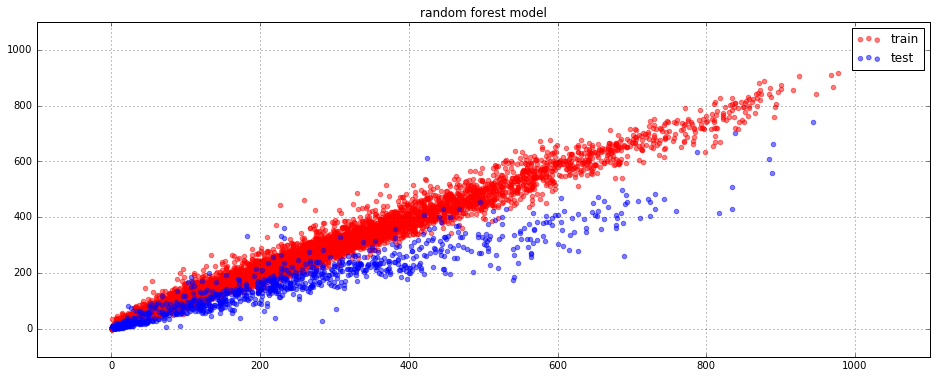

In [176]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
train_rfr = pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
test_rfr = pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')
pylab.legend([train_rfr, test_rfr], ['train', 'test'])

### Теперь сформируем ответ на тестовую выборку для ресурса kaggle

In [177]:
raw_test = pd.read_csv('test.csv', header=0, sep=',')

In [178]:
raw_test.datetime = raw_test.datetime.apply(pd.to_datetime)

# new features
raw_test['month'] = raw_test.datetime.apply(lambda x: x.month)
raw_test['hour'] = raw_test.datetime.apply(lambda x: x.hour)
#тест
test_labels_datetime = raw_test['datetime'].values
test_data = raw_test.drop(['datetime'], axis=1)

In [179]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [180]:
raw_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,4


In [181]:
test_predictions

array([ 14.16,   5.68,   5.2 , ...,  81.1 ,  91.7 ,  49.35])

In [182]:
result = pd.DataFrame({'datetime':test_labels_datetime})

In [183]:
result.insert(1, 'count', test_predictions)

In [184]:
result[['datetime', 'count']].to_csv('result.csv', sep=',', encoding='utf-8', index=False)

#### Наш итог

In [185]:
result

,datetime,count
0,2011-01-20 00:00:00,14.160000
1,2011-01-20 01:00:00,5.680000
2,2011-01-20 02:00:00,5.200000
3,2011-01-20 03:00:00,3.900000
4,2011-01-20 04:00:00,3.100000
5,2011-01-20 05:00:00,17.360000
6,2011-01-20 06:00:00,63.740000
7,2011-01-20 07:00:00,147.200000
8,2011-01-20 08:00:00,325.480000
9,2011-01-20 09:00:00,186.500000
